# Generate gamma

#### Done By Yuliia Hetman

In [1]:
from matplotlib import pyplot as plt
import scipy.io.wavfile as wavfile
import seaborn as sns
import numpy as np
import sys
sns.set()
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10, 3)

## Twelve-tone equal temperament

f(i) = f_0 * 2^(i/12)<br/>
f(i) - the pitch, or frequency (usually in hertz), we need to find;<br/>
f_0 - the frequency of the reference pitch.

The reference pitch also known as Stuttgart pitch is A4, the 49th key from the left end of a piano, tuned to 440 Hz.<br/>

In [2]:
A4 = 440

For the First octave we have the following notation of notes:<br/>
C4 -- 40th key <br/>
D4 -- 42th key <br/>
E4 -- 44th key <br/>
F4 -- 45th key <br/>
G4 -- 47th key <br/>
A4 -- 49th key <br/>
B4 -- 51th key .

## First we need to define musical constants.

Octavas - is a dictionary of serial numbers of octavas on the piano as keys and their ratios with 4th octava as values.

Keys_interval - amount of semitones between the A key and other keys of the octava.

Keys - a sequence of all keys in the octava.

Tonality - dictionary were keys represent types of the tonality, and values are defined as lists of semitones that you need to add to the first note of the octava to get gamma in the particular tonality.

In [3]:
octavas = { 0 : 0.0625,
            1 : 0.125,
            2 : 0.25,
            3 : 0.5,
            4 : 1,
            5 : 2,
            6 : 4,
            7 : 8,
            8 : 16}


keys_interval =  {
    'C' : -9,
    'D': -7,
    'E' : -5,
    'F' : -4,
    'G' : -2,
    'A' : 0,
    'B' : 2,
}

keys = ['C', 'D', 'E', 'F', 'G', 'A', 'B']

tonality = {
        'major' : [0, 2, 4, 5, 7, 9, 11, 12],
        'minor' : [0, 2, 3, 5, 7, 8, 10, 12]
               }

In [4]:
sample_rate = 44100               # sample rate
sample_period = 1 / sample_rate   # sample period
t = 1                             # seconds of sampling
N = sample_rate * t               # total points in signal
t_vec = np.arange(N) * sample_period

### Define tonality we want to generate

In [5]:

def check_bemol(key):
    if len(key) > 1 and key[-1] == 'b':
        return True
    else:
        return False

def check_dies(key):
    if len(key) > 1 and key[-1] == '#':
        return True
    else:
        return False

def get_gamma_frequencies(key='C', octava=4, ton='major'):
    A_key = 12 * octava + 1
    if check_bemol(key) == True:
        key = key[0]
        first_key = A_key + keys_interval[key] - 1
    elif check_dies(key) == True:
        key = key[0]
        first_key = A_key + keys_interval[key] + 1
    else:
        first_key = A_key + keys_interval[key]
    sequence = keys[keys.index(key):] + keys[:keys.index(key) + 1]
    gamma = dict()
    for i in range(0, 8):
        note = sequence[i]
        A_key = 12 * octava + 1
        piano_key = first_key + tonality[ton][i]
        if 'B' + str(octava) in list(gamma.keys()):
            gamma[note + str(octava + 1)] = octavas[octava] * A4 *  (2 ** ((piano_key - A_key) / 12)) 
        else:
            gamma[note + str(octava)] = octavas[octava] * A4 *  (2 ** (( piano_key - A_key) / 12)) 
    return gamma


## Sine Wave Sampling

In [6]:

def sine_wave_sampling(gamma_frequencies):
    notes = [np.sin( 2 * np.pi * v * t_vec) for v in gamma_frequencies.values()]
    gamma = np.concatenate(notes)
    print(gamma.shape)
    plt.plot(gamma[::2000], 'g')
    plt.xlabel("Time -->")
    plt.ylabel("<-- Signal -->")
    plt.show()
    normalized_gamma = np.int16((gamma / gamma.max()) * 32767)
    filename = 'sine_waves_'+ "_".join([key, ton, str(octava)]) +'.wav'
    wavfile.write(filename, sample_rate, normalized_gamma)
    print("Generated notes were saved to file:", filename)
    return gamma

## Inverse Fourier Transformation

In [7]:
def inverse_fourier_sampling(gamma_frequencies):
    notes = []
    for v in gamma_frequencies.values():
        A = np.zeros(int(sample_rate / 2))
        A[int(v)] = sample_rate / 2
        notes.append(np.fft.irfft(A))
    gamma = np.concatenate(notes)
    plt.plot(gamma[::2000], 'red')
    plt.xlabel("Time -->")
    plt.ylabel("<-- Signal -->")
    plt.show()
    filename = 'irftt_'+ "_".join([key, ton, str(octava)]) +'.wav'
    wavfile.write(filename, sample_rate, gamma)
    print("Generated notes were saved to file:", filename)
    return gamma

## Delete noises

In [8]:
def clean_sound(gamma):
    fft_spectrum = np.fft.rfft(gamma)
    fr = np.fft.rfftfreq(gamma.size, d=sample_period)
    fft_spectrum_abs = np.abs(fft_spectrum)
    plt.subplot(2,1,1)
    plt.plot(fr, fft_spectrum_abs, 'blue')
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    for i,f in enumerate(fr):
        if f < 16 or f > 8000:
            fft_spectrum[i] = 0.0
    plt.subplot(2,1,2)
    plt.plot(fr[10:8000], np.abs(fft_spectrum)[10:8000],'green')
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    noiseless_signal = np.fft.irfft(fft_spectrum)
    filename = "_".join([key, ton, str(octava)]) +'.wav'
    wavfile.write(filename, sample_rate, noiseless_signal)
    print("Generated notes were saved to file:", filename)

## Generate any gamma

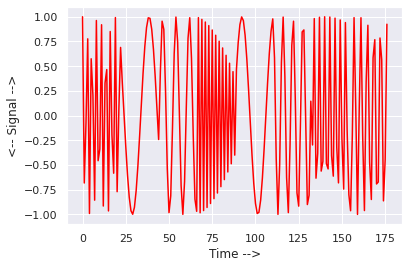

Generated notes were saved to file: irftt_Bb_minor_1.wav


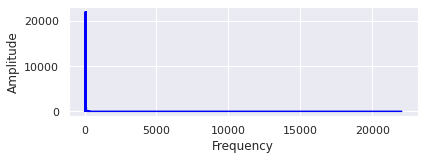

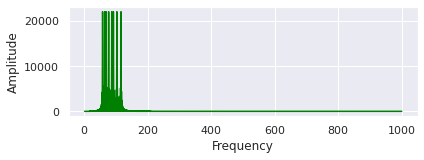

Generated notes were saved to file: Bb_minor_1.wav


In [14]:
key = 'Bb'
octava = 1
ton = 'minor'

gamma_frequencies = get_gamma_frequencies(key=key, octava=octava, ton=ton)
gamma = inverse_fourier_sampling(gamma_frequencies)
clean_sound(gamma)